# Predicting Vehicle Accidents with Machine Learning - a Complete pipeline in Python.


Every year 1.3 Million people die in road crashes - that is 3,287 deaths per DAY. Currently, car crashes are the 9th leading cause of death and they are predicted to be 5th leading cause by 2030 unless we do something to change it. Each year, car crashes cost $518 Billion in damages, costing individual countries between 1-2% of their gdp. 

This project seeks to understand the causes and factors behind car crash severity. 

---

Dataset: **New Zealand Crash Analysis Dastaset**
This data was extracted from the New Zealand Transport Agency Crash Analysis System (CAS). It is updated on a quarterly basis. CAS records all crashes that are reported to the Transport Agency by the NZ Police. Not all crashes are reported to the NZ police and the level of reporting depends on the severity.

---

This notebook walks through getting the data, analyzing it, exploring it on a map, and running a random forest regression.


*by: Marissa Posner & Dominick Ancona*


## Installs



In [ ]:
!pip install geopandas
!pip install descartes 
!pip install folium 
!pip install pysal
!pip install scipy
!pip install -U scikit-learn
!pip install seaborn --upgrade
!pip install xgboost

Requirement already up-to-date: scikit-learn in ./anaconda3/lib/python3.6/site-packages (0.21.0)
Requirement already up-to-date: seaborn in ./anaconda3/lib/python3.6/site-packages (0.9.0)
  Using cached https://files.pythonhosted.org/packages/2e/bd/ad3a963b630fa3ee72d1a672fd207263fa0a18113688273afe8298293535/xgboost-0.82.tar.gz


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import requests
import seaborn as sns

## Getting the Data

The Crash Analysis System (CAS) data is available in different formats and APIs. It is simple to grab them through API interfaces, instead of downloading to your local machine. This is beneficial, as we will access latest updated data every time we run the Jupyter notebook. I find this particular problem, the vehicle accidents, to be strongly related to location (Geography), so we will grab the geojson, instead of usual csv file, so that we can perform geographic data analysis without creating geometries from latitude and longtitude and deal with coordinate reference systems and projections. 

We will use Geopandas library to read the data. If you are familiar with Pandas library, then you should feel home as Geopandas is built on top pandas. Geopandas is high level library that makes working with geographic data in Python easier as it allows pandas functionality and data types to allow spatial operations on geographic geometries. It is well integrated with the python echosystem and depends much on pandas, matplotlib and shapely library for geometric operations.

In [2]:
# Get the data from url and request it as json file
url = 'https://opendata.arcgis.com/datasets/a163c5addf2c4b7f9079f08751bd2e1a_0.geojson'
geojson = requests.get(url).json()

In [ ]:
#Get the data from url and request it as json file
# url = 'https://services.arcgis.com/CXBb7LAjgIIdcsPt/arcgis/rest/services/Crash_Analysis_System_Data/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
# geojson = requests.get(url, geoJSON='GEOJSON').json()

In [3]:
# Read the data as GeodataFrame in Geopandas
#get it into coords system 
crs = {'init': 'epsg:3851'} # Coordinate reference system (CRS) for New zealand with epsg code: 3851
gdf = gpd.GeoDataFrame.from_features(geojson['features'], crs=crs)

In [4]:
gdf.columns


Index(['OBJECTID', 'OBJECTID_1', 'Pedestrian', 'advisorySp', 'animals',
       'areaUnitID', 'bicycle', 'bridge', 'bus', 'carStation', 'cliffBank',
       'cornerRoad', 'crashDirec', 'crashDista', 'crashFinan', 'crashLoc_1',
       'crashLocat', 'crashRPDir', 'crashRPDis', 'crashRPNew', 'crashRPRS',
       'crashRPSH', 'crashSHDes', 'crashSever', 'crashYear', 'darkLight',
       'debris', 'directionR', 'ditch', 'easting', 'fatalCount', 'fence',
       'flatHill', 'geometry', 'guardRail', 'holiday', 'houseBuild',
       'intersec_1', 'intersecti', 'junctionTy', 'kerb', 'light', 'meshblockI',
       'minorInjur', 'moped', 'motorcycle', 'multiVehic', 'northing',
       'numberOfLa', 'objectThro', 'other', 'otherVehic', 'outdatedLo',
       'overBank', 'parkedVehi', 'phoneBoxEt', 'postOrPole', 'regionDesc',
       'roadCharac', 'roadCurvat', 'roadLane', 'roadMarkin', 'roadSurfac',
       'roadWet', 'roadworks', 'schoolBus', 'seriousInj', 'slipFlood',
       'speedLimit', 'strayAnima', 'str

In [5]:
gdf.shape

(674321, 89)

## Exploratoray Data Analysis

### Crash 
Data fields:
**crashSeverity**: The severity of a crash. Possible values are 'F' (fatal), 'S' (serious), 'M' (minor), 'N' (non-injury). This is determined by the worst injury sustained in the crash at time of entry.

**seriousInjuryCount**: A count of the number of serious injuries (inj) associated with this crash.

**minorInjuryCount**: A count of the number of minor injuries (inj) associated with this crash.

**fatalCount:** A count of the number of fatal casualties associated with this crash.

In [7]:
gdf['crashSever']

0         S
1         M
2         M
3         M
4         M
5         M
6         M
7         S
8         M
9         M
10        S
11        M
12        M
13        M
14        M
15        M
16        S
17        M
18        M
19        M
20        S
21        M
22        M
23        S
24        M
25        S
26        M
27        S
28        M
29        M
         ..
674291    N
674292    N
674293    N
674294    N
674295    N
674296    N
674297    N
674298    N
674299    N
674300    N
674301    N
674302    N
674303    N
674304    N
674305    N
674306    N
674307    N
674308    N
674309    N
674310    N
674311    N
674312    N
674313    N
674314    N
674315    N
674316    N
674317    N
674318    N
674319    N
674320    N
Name: crashSever, Length: 674321, dtype: object

In [4]:
start_year = gdf.crashYear.min()
end_year = gdf.crashYear.max()

fatal = gdf['fatalCount'].sum()
minor = gdf['minorInjur'].sum()
major = gdf['seriousInj'].sum()


print("The total death in car crash accidents since the year {}, up to {} is {}.".format(start_year, end_year,fatal))
print("While the total number of serious injuries and minor injuries in car accidents reach {}, {} respectively".format(major,minor))

The total death in car crash accidents since the year 2000, up to 2018 is 6991.
While the total number of serious injuries and minor injuries in car accidents reach 45604, 208623 respectively


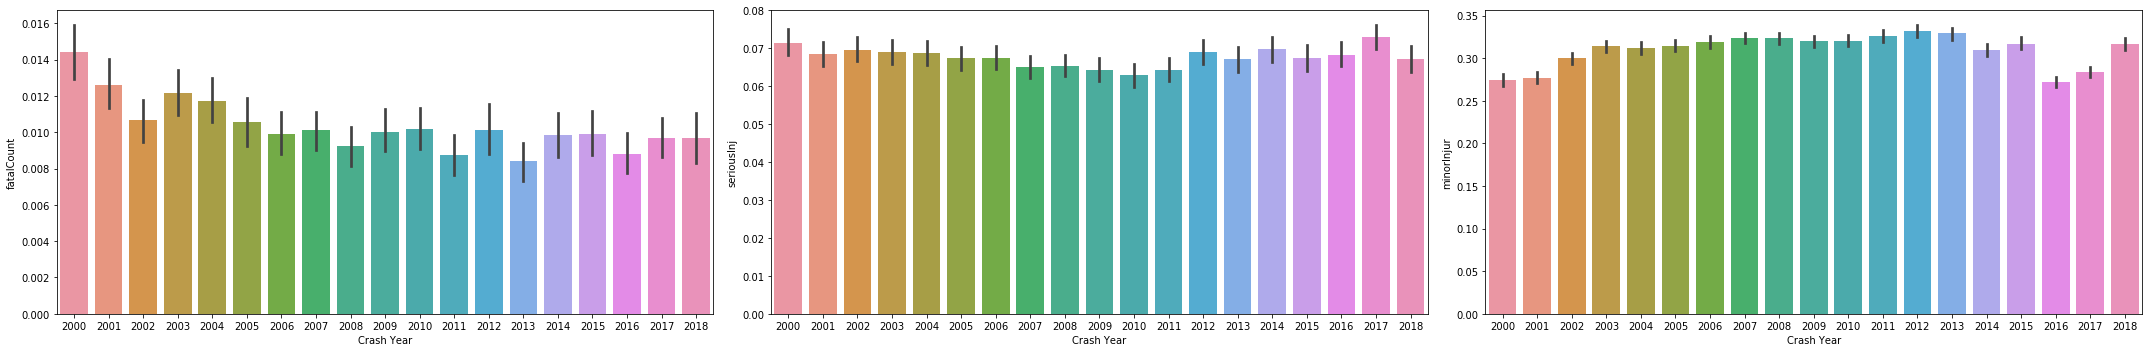

In [9]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5));

sns.barplot(x="crashYear", y="fatalCount",  data=gdf, ax=ax[0]);
sns.barplot(x="crashYear", y="seriousInj",  data=gdf, ax=ax[1]);
sns.barplot(x="crashYear", y="minorInjur",  data=gdf, ax=ax[2]);
[ax[i].set_xlabel('Crash Year') for i in range(3)]
plt.tight_layout()

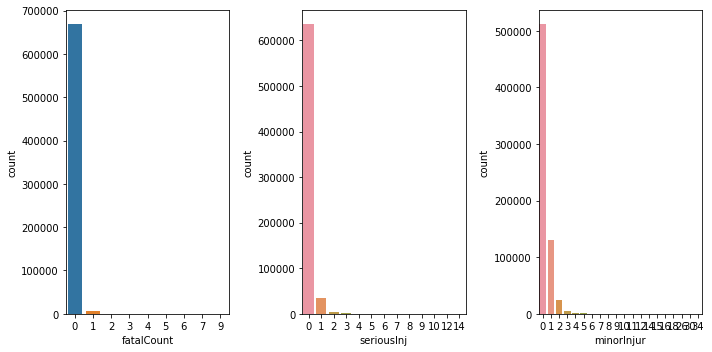

In [10]:
fig, ax = plt.subplots(1, 3, figsize = (10, 5));
sns.countplot(x="fatalCount",data=gdf, ax=ax[0])
sns.countplot(x="seriousInj",data=gdf, ax=ax[1])
sns.countplot(x="minorInjur",data=gdf, ax=ax[2]);

plt.tight_layout()

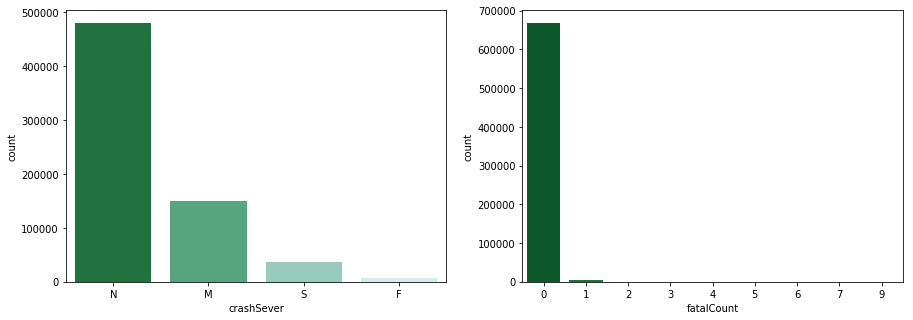

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5));
sns.countplot(x="crashSever",data=gdf, palette="BuGn_r", order='NMSF',ax = ax[0]);
sns.countplot(x="fatalCount",data=gdf, palette="BuGn_r", ax=ax[1]);

# Plot crashes per year based on attributes

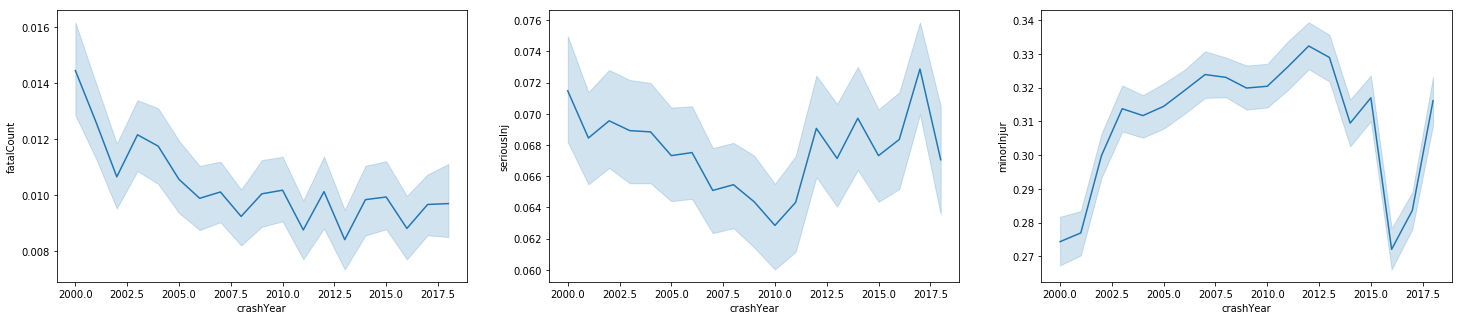

In [6]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5)); # 1 row 3 cols 
sns.lineplot(x="crashYear", y="fatalCount",data=gdf, ax=ax[0],palette='husl');
sns.lineplot(x="crashYear", y="seriousInj",data=gdf, ax=ax[1],palette='husl');
sns.lineplot(x="crashYear", y="minorInjur",data=gdf, ax=ax[2],palette='husl');

### Roads 


In [ ]:
#get columns
gdf.columns

Index(['OBJECTID', 'OBJECTID_1', 'Pedestrian', 'advisorySp', 'animals',
       'areaUnitID', 'bicycle', 'bridge', 'bus', 'carStation', 'cliffBank',
       'cornerRoad', 'crashDirec', 'crashDista', 'crashFinan', 'crashLoc_1',
       'crashLocat', 'crashRPDir', 'crashRPDis', 'crashRPNew', 'crashRPRS',
       'crashRPSH', 'crashSHDes', 'crashSever', 'crashYear', 'darkLight',
       'debris', 'directionR', 'ditch', 'easting', 'fatalCount', 'fence',
       'flatHill', 'geometry', 'guardRail', 'holiday', 'houseBuild',
       'intersec_1', 'intersecti', 'junctionTy', 'kerb', 'light', 'meshblockI',
       'minorInjur', 'moped', 'motorcycle', 'multiVehic', 'northing',
       'numberOfLa', 'objectThro', 'other', 'otherVehic', 'outdatedLo',
       'overBank', 'parkedVehi', 'phoneBoxEt', 'postOrPole', 'regionDesc',
       'roadCharac', 'roadCurvat', 'roadLane', 'roadMarkin', 'roadSurfac',
       'roadWet', 'roadworks', 'schoolBus', 'seriousInj', 'slipFlood',
       'speedLimit', 'strayAnima', 'str

roadworks, junctionTy
roadCharac
roadCurvat
roadLane
roadMarkin
roadSurfac
roadWet
numberOfLa
intersecti
flatHill
 darkLight

*Plot the different road attributes*

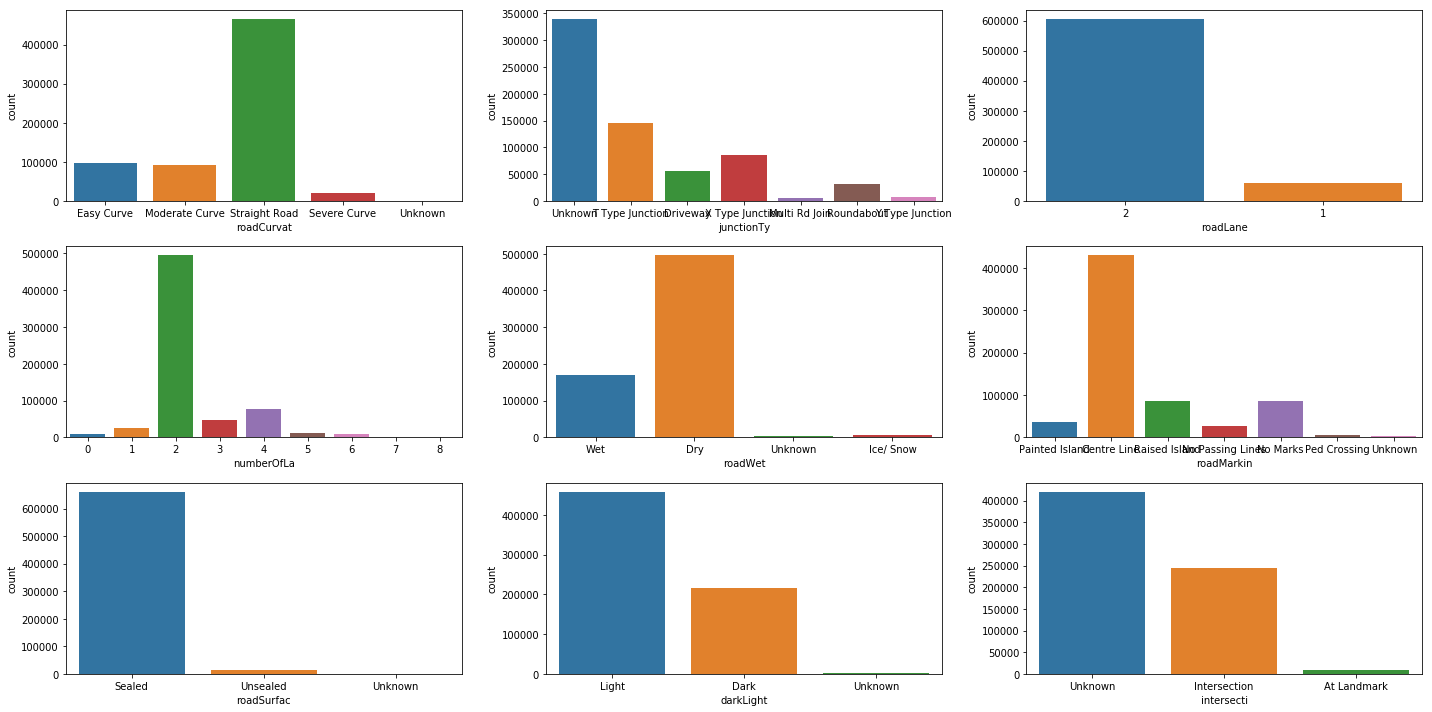

In [7]:
fig, ax = plt.subplots(3, 3, figsize = (20, 10));

sns.countplot(x='roadCurvat',data=gdf, ax=ax[0,0])
sns.countplot(x="junctionTy",data=gdf,  ax=ax[0,1])
sns.countplot(x='roadLane',data=gdf, ax=ax[0,2])
sns.countplot(x='numberOfLa',data=gdf, ax=ax[1,0])
sns.countplot(x='roadWet',data=gdf, ax=ax[1,1])
sns.countplot(x='roadMarkin',data=gdf,  ax=ax[1,2])
sns.countplot(x='roadSurfac',data=gdf, ax=ax[2,0])
sns.countplot(x='darkLight',data=gdf, ax=ax[2,1])
sns.countplot(x='intersecti',data=gdf, ax=ax[2,2])

plt.tight_layout()


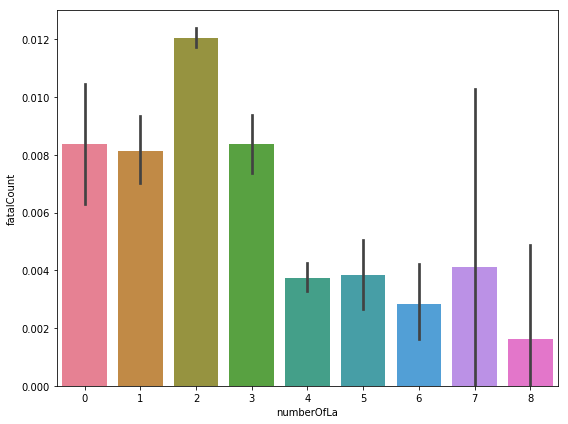

In [29]:
plt.figure(figsize=(8,6))
sns.barplot(x='numberOfLa',y = 'fatalCount',data=gdf, palette='husl')
plt.tight_layout();

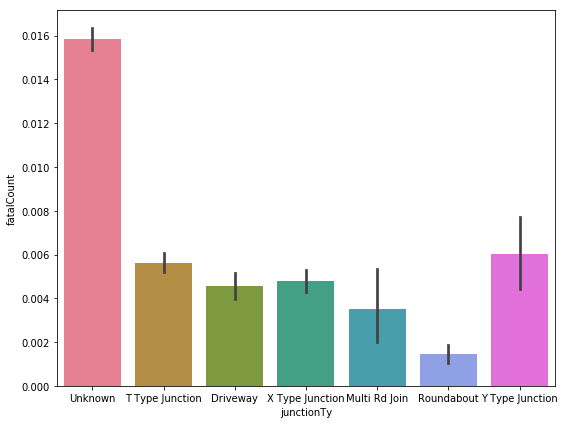

In [25]:
plt.figure(figsize=(8,6))
sns.barplot(x='junctionTy',y = 'fatalCount',data=gdf, palette="husl")
plt.tight_layout()

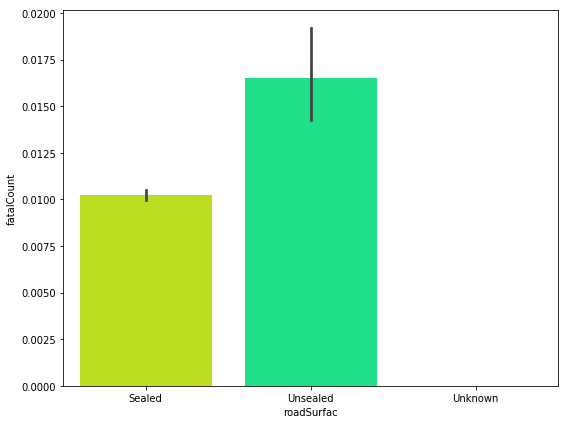

In [4]:
plt.figure(figsize=(8,6))
sns.barplot(x='roadSurfac',y = 'fatalCount',data=gdf, palette="gist_rainbow")
plt.tight_layout()

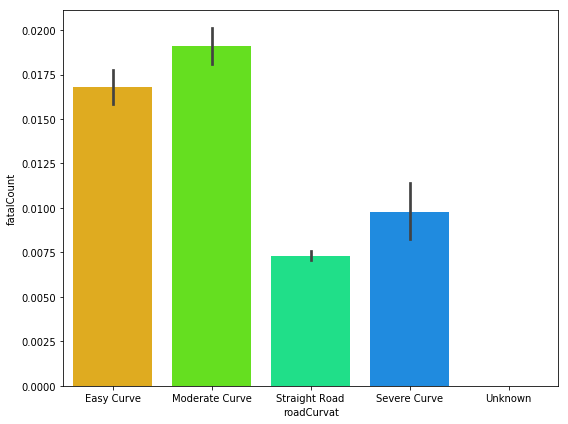

In [55]:
plt.figure(figsize=(8,6))
sns.barplot(x='roadCurvat',y = 'fatalCount',data=gdf, palette="gist_rainbow")
plt.tight_layout()

### Traffic

*Fatality counts by speed limit*

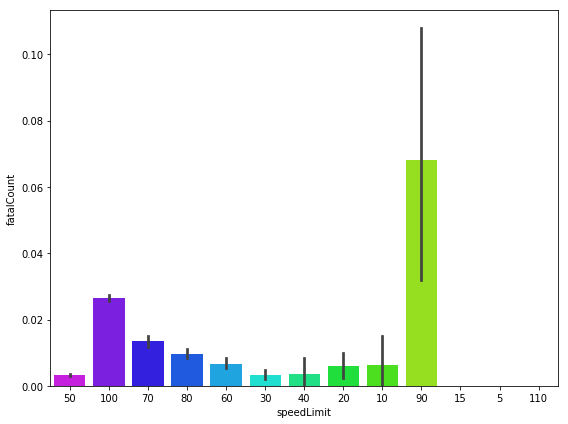

In [50]:
plt.figure(figsize=(8,6))
sns.barplot(x="speedLimit", y="fatalCount",  data=gdf,palette='gist_rainbow_r');
plt.tight_layout()

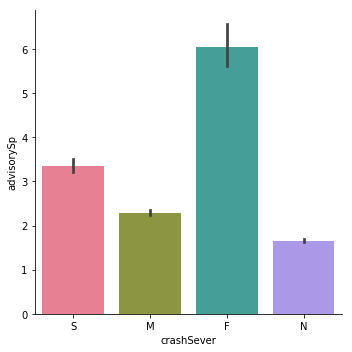

In [52]:
sns.catplot(x="crashSever", y="advisorySp",data=gdf, kind= 'bar',palette='husl');

### Weather

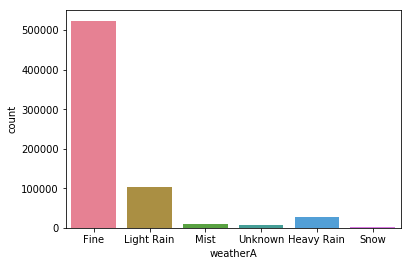

In [53]:
sns.countplot(x="weatherA",data=gdf, palette="husl");


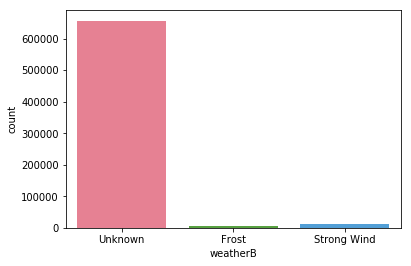

In [54]:
sns.countplot(x="weatherB",data=gdf, palette="husl");

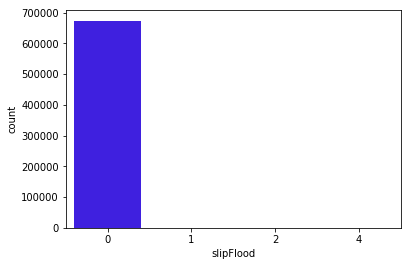

In [56]:
#slip or flood
sns.countplot(x="slipFlood",data=gdf, palette="gist_rainbow_r");
#ok so not really a field

Check fatality counts for each type of weather 

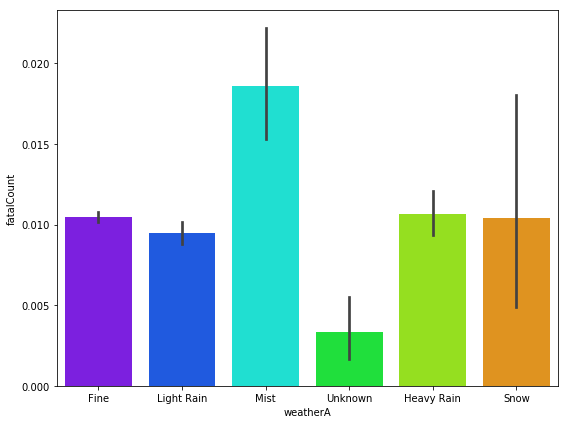

In [57]:
plt.figure(figsize=(8,6))
sns.barplot(x="weatherA", y="fatalCount",  data=gdf,palette='gist_rainbow_r');
plt.tight_layout()

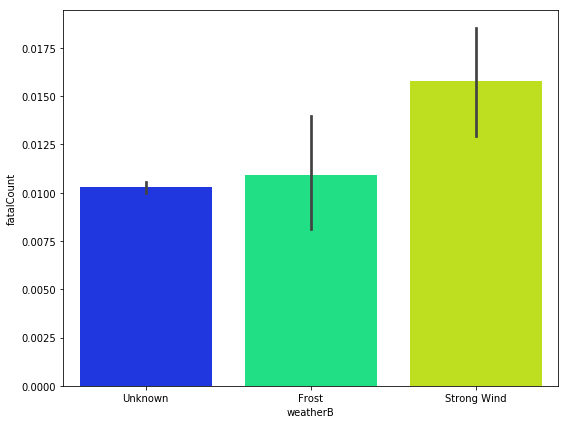

In [58]:
plt.figure(figsize=(8,6))
sns.barplot(x="weatherB", y="fatalCount",  data=gdf,palette='gist_rainbow_r');
plt.tight_layout()

In [ ]:
gdf.columns

### Pearson Correlation: the extent to which two variables are linearly related

In [4]:
selected_cols = ['weatherA', 'weatherB','speedLimit','fatalCount', "advisorySp", 
                     'roadCurvat', 'roadLane', 'numberOfLa' ]

In [ ]:
# This might take a while so skip !
# k = 5 
# f,ax = plt.subplots(figsize=(12, 12))
# cols = gdf.corr().nlargest(k, 'fatalCount')['fatalCount'].index
# cm = np.corrcoef(gdf[selected_cols].values.T)
# sns.set(font_scale=1.25)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# #plt.show()

## Geographic Data Exploration

Plot the geodataframe 

In [6]:
gdf

,OBJECTID,OBJECTID_1,Pedestrian,advisorySp,animals,areaUnitID,bicycle,bridge,bus,carStation,...,train,tree,truck,unknownVeh,urban,vanOrUtili,vehicle,waterRiver,weatherA,weatherB
0,2001,667848,0,0,0,527820,0,0,0,1,...,0,1,0,0,Urban,0,0,0,Fine,Unknown
1,2002,667849,0,0,0,527924,0,0,0,1,...,0,0,0,0,Openroad,0,0,0,Fine,Unknown
2,2003,667850,0,0,0,536821,0,0,0,4,...,0,0,0,0,Urban,0,0,0,Light Rain,Unknown
3,2004,667851,0,0,0,538201,0,0,0,3,...,0,0,0,0,Urban,0,0,0,Fine,Unknown
4,2005,667852,0,0,0,542410,0,0,0,1,...,0,0,0,0,Urban,0,0,0,Fine,Unknown
5,2006,667853,0,0,0,538820,0,0,0,0,...,0,0,1,0,Openroad,0,0,0,Fine,Unknown
6,2007,667854,0,0,0,516003,0,0,0,0,...,0,0,0,0,Openroad,0,0,0,Light Rain,Unknown
7,2008,667855,1,0,0,513430,0,0,0,1,...,0,0,0,0,Urban,0,0,0,Fine,Unknown
8,2009,667856,0,0,0,535250,0,0,0,2,...,0,0,0,0,Openroad,0,0,0,Fine,Unknown
9,2010,667857,0,0,0,528406,0,0,0,2,...,0,0,0,0,Openroad,0,0,0,Fine,Unknown


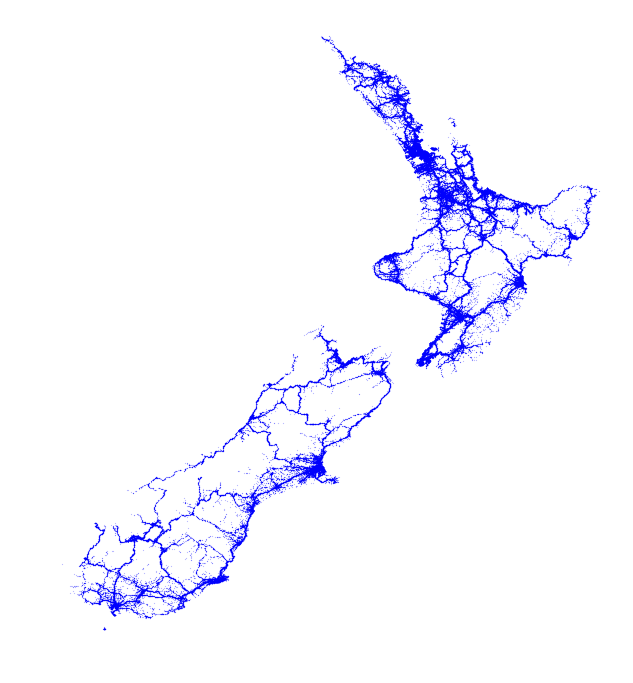

In [61]:
gdf.plot(markersize=0.01, edgecolor='blue',figsize=(12,12));
plt.axis('off');

In [63]:
#folium is a library to create leaflet maps
#tiles are the layout of the map essentially or how it looks 
from folium.plugins import MarkerCluster
gdf_sample = gdf.sample(5000)
lons = gdf_sample.geometry.x
lats = gdf_sample.geometry.y

m = folium.Map(
    location=[np.mean(lats), np.mean(lons)],
    tiles='Cartodb Positron',
    zoom_start=6
)

#FastMarkerCluster(data=list(zip(lats, lons))).add_to(m)
MarkerCluster(list(zip(lats, lons))).add_to(m)

folium.LayerControl().add_to(m)
m


# Heat Map of Accidents

In [58]:
gdf_sample = gdf.sample(5000)
lons = gdf_sample.geometry.x
lats = gdf_sample.geometry.y
heat_cols = list(zip(lats, lons))
from folium.plugins import HeatMap

m = folium.Map([np.mean(lats), np.mean(lons)], 
               tiles='CartoDB dark_matter', 
               zoom_start=6)

HeatMap(heat_cols).add_to(m)
m


In [4]:
gdf['lons'] = gdf.geometry.x
gdf['lats'] = gdf.geometry.y
gdf.columns

Index(['OBJECTID', 'OBJECTID_1', 'Pedestrian', 'advisorySp', 'animals',
       'areaUnitID', 'bicycle', 'bridge', 'bus', 'carStation', 'cliffBank',
       'cornerRoad', 'crashDirec', 'crashDista', 'crashFinan', 'crashLoc_1',
       'crashLocat', 'crashRPDir', 'crashRPDis', 'crashRPNew', 'crashRPRS',
       'crashRPSH', 'crashSHDes', 'crashSever', 'crashYear', 'darkLight',
       'debris', 'directionR', 'ditch', 'easting', 'fatalCount', 'fence',
       'flatHill', 'geometry', 'guardRail', 'holiday', 'houseBuild',
       'intersec_1', 'intersecti', 'junctionTy', 'kerb', 'light', 'meshblockI',
       'minorInjur', 'moped', 'motorcycle', 'multiVehic', 'northing',
       'numberOfLa', 'objectThro', 'other', 'otherVehic', 'outdatedLo',
       'overBank', 'parkedVehi', 'phoneBoxEt', 'postOrPole', 'regionDesc',
       'roadCharac', 'roadCurvat', 'roadLane', 'roadMarkin', 'roadSurfac',
       'roadWet', 'roadworks', 'schoolBus', 'seriousInj', 'slipFlood',
       'speedLimit', 'strayAnima', 'str

Another map

In [5]:
import matplotlib 
import matplotlib.colors as c

from mpl_toolkits.axes_grid1 import make_axes_locatable

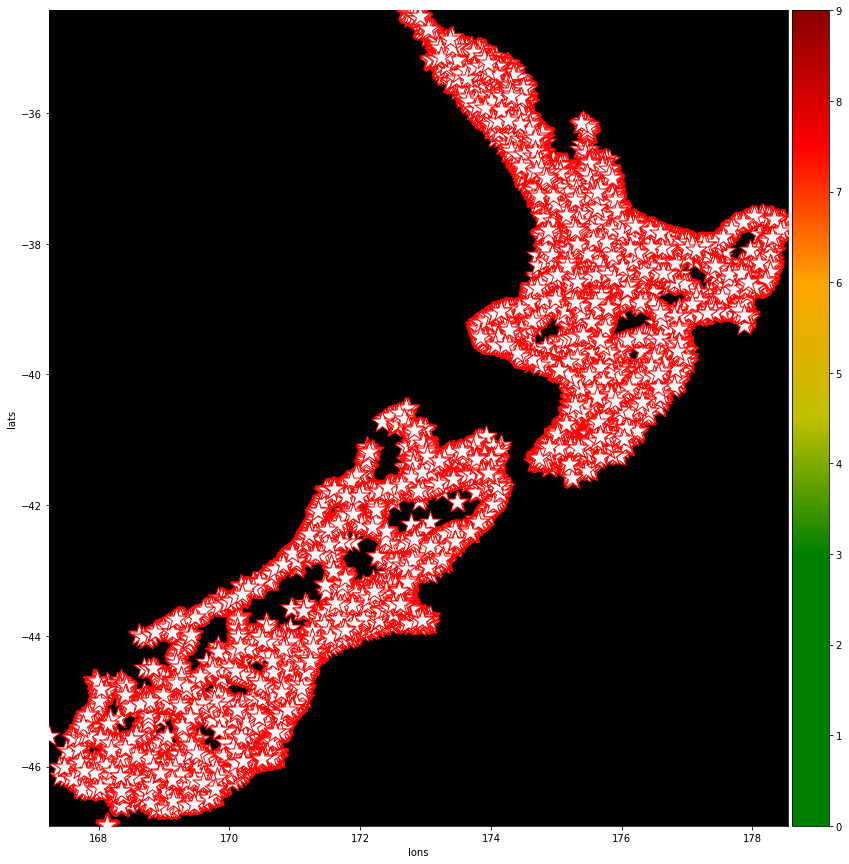

In [20]:
gdf_to_df = pd.DataFrame(gdf.drop(columns='geometry'))
cmap = c.LinearSegmentedColormap.from_list('traffic',['g','g','g','y','orange','r','darkred'])
x=gdf['lons']
y=gdf['lats']
fig,ax = plt.subplots()
fig.set_size_inches((15,15))
plt.gca().set_facecolor('k')
plt.imshow(np.array([[gdf_to_df.fatalCount.min(),gdf.fatalCount.max()]]),origin='lower',cmap=cmap)
gdf_to_df.plot.scatter(x='lons',y='lats',
                             ax=ax,
                             s=500,
                             color='w',
                             zorder=9e99,
                             marker='*',
                             edgecolors='r',ylim=y.max())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_xbound(lower=x.min(),upper=x.max())
ax.set_ybound(lower=y.min(),upper=y.max())
# cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax);

## Machine Learning Model - Regression

Predicting the number of fatalities based on the attributes of the crash datase

Dependent Variable (y): fatalCount 
Independent variables: all other variables

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [10]:
gdf.head()

,OBJECTID,OBJECTID_1,Pedestrian,advisorySp,animals,areaUnitID,bicycle,bridge,bus,carStation,...,train,tree,truck,unknownVeh,urban,vanOrUtili,vehicle,waterRiver,weatherA,weatherB
0,2001,667848,0,0,0,527820,0,0,0,1,...,0,1,0,0,Urban,0,0,0,Fine,Unknown
1,2002,667849,0,0,0,527924,0,0,0,1,...,0,0,0,0,Openroad,0,0,0,Fine,Unknown
2,2003,667850,0,0,0,536821,0,0,0,4,...,0,0,0,0,Urban,0,0,0,Light Rain,Unknown
3,2004,667851,0,0,0,538201,0,0,0,3,...,0,0,0,0,Urban,0,0,0,Fine,Unknown
4,2005,667852,0,0,0,542410,0,0,0,1,...,0,0,0,0,Urban,0,0,0,Fine,Unknown


In [7]:
#Change data from geodataframe to dataframe. Dropping geo and objectID cols bc wont matt4er
df = pd.DataFrame(gdf.drop(['geometry','OBJECTID'], axis = 1))
df.head()

,OBJECTID_1,Pedestrian,advisorySp,animals,areaUnitID,bicycle,bridge,bus,carStation,cliffBank,...,truck,unknownVeh,urban,vanOrUtili,vehicle,waterRiver,weatherA,weatherB,lons,lats
0,667848,0,0,0,527820,0,0,0,1,0,...,0,0,Urban,0,0,0,Fine,Unknown,175.226860,-37.820620
1,667849,0,0,0,527924,0,0,0,1,1,...,0,0,Openroad,0,0,0,Fine,Unknown,175.289010,-37.998924
2,667850,0,0,0,536821,0,0,0,4,0,...,0,0,Urban,0,0,0,Light Rain,Unknown,176.193733,-37.665581
3,667851,0,0,0,538201,0,0,0,3,0,...,0,0,Urban,0,0,0,Fine,Unknown,176.160955,-37.695747
4,667852,0,0,0,542410,0,0,0,1,0,...,0,0,Urban,0,0,0,Fine,Unknown,176.981378,-37.957300


### Random Forest

One hot encoding: Convert the categorical variables into numerical variables. 

In [11]:
df.select_dtypes('object')

,crashDirec,crashFinan,crashLoc_1,crashLocat,crashRPDir,crashRPNew,crashRPSH,crashSHDes,crashSever,darkLight,...,roadMarkin,roadSurfac,roadWet,speedLimit,streetLigh,tlaName,trafficCon,urban,weatherA,weatherB
0,South,1999/2000,COWLEY DRIVE,TUHIKARAMEA ROAD,0,0,0,No,S,Light,...,Painted Island,Sealed,Wet,50,Off,Hamilton City,Nil,Urban,Fine,Unknown
1,West,1999/2000,ALEXANDRA ST,PIRONGIA ROAD,0,0,0,No,M,Dark,...,Centre Line,Sealed,Dry,100,None,Waipa District,Nil,Openroad,Fine,Unknown
2,West,1999/2000,HOCKING ST,SH 2,None,0,2,Yes,M,Dark,...,Centre Line,Sealed,Wet,70,On,Tauranga City,Nil,Urban,Light Rain,Unknown
3,South,1999/2000,NINTH AVENUE,CAMERON ROAD,0,0,0,No,M,Light,...,Raised Island,Sealed,Dry,50,Off,Tauranga City,Nil,Urban,Fine,Unknown
4,None,1999/2000,HIKURANGI ST,EIVERS ROAD,0,0,0,No,M,Light,...,Centre Line,Sealed,Dry,50,Off,Whakatane District,Give Way Sign,Urban,Fine,Unknown
5,South,1999/2000,COOKSON ROAD,SH 30,None,0,30,Yes,M,Dark,...,Centre Line,Sealed,Dry,100,None,Rotorua District,Nil,Openroad,Fine,Unknown
6,South,1999/2000,GREENLANE ON SBD,SH 1N,None,None,None,Yes,M,Light,...,Raised Island,Sealed,Wet,100,Off,Auckland,Nil,Openroad,Light Rain,Unknown
7,North,1999/2000,WESTPARK DRIVE,HOBSONVILLE ROAD,0,0,0,No,S,Light,...,Painted Island,Sealed,Dry,50,Off,Auckland,Nil,Urban,Fine,Unknown
8,None,1999/2000,SH 5,SH 1N,0,0,None,Yes,M,Light,...,Painted Island,Sealed,Dry,100,Off,South Waikato District,Stop Sign,Openroad,Fine,Unknown
9,South,1999/2000,GILCHRIST ST,SH 1N,0,0,None,Yes,M,Light,...,No Passing Lines,Sealed,Dry,80,Off,Hamilton City,Nil,Openroad,Fine,Unknown


In [42]:
df['darkLight'].unique()

array(['Light', 'Dark', 'Unknown'], dtype=object)

# One Hot Encoding

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

In [9]:
# Label encoder
le = LabelEncoder()
# cat_vars=['roadSurfac','roadWet','weatherA','weatherB','roadCurvat','darkLight','urban','roadMarkin','crashSever','streetLigh','directionR']
# for var in cat_vars:
#     cat_list='var'+'_'+var
#     cat_list = pd.get_dummies(df[var], prefix=var)
#     df1=df.join(cat_list)
#     df=df1

for i in df.columns:
    if df[i].dtype==type(object):
        df[i] = le.fit_transform(df[i].astype(str))

# df=encoder(df)
# df

In [10]:
# One Hot Encoding
df = pd.get_dummies(df)


In [15]:
# data_vars=df.columns.values.tolist()
# to_keep=[i for i in data_vars if i not in cat_vars]
# df_final=df[to_keep]
# df_final.columns.values

Split  data into training and validation sets

In [43]:
df.dtypes

OBJECTID_1      int64
Pedestrian      int64
advisorySp      int64
animals         int64
areaUnitID      int64
bicycle         int64
bridge          int64
bus             int64
carStation      int64
cliffBank       int64
cornerRoad    float64
crashDirec      int64
crashDista      int64
crashFinan      int64
crashLoc_1      int64
crashLocat      int64
crashRPDir      int64
crashRPDis      int64
crashRPNew      int64
crashRPRS       int64
crashRPSH       int64
crashSHDes      int64
crashSever      int64
crashYear       int64
darkLight       int64
debris          int64
directionR      int64
ditch           int64
easting         int64
fatalCount      int64
               ...   
roadMarkin      int64
roadSurfac      int64
roadWet         int64
roadworks       int64
schoolBus       int64
seriousInj      int64
slipFlood       int64
speedLimit      int64
strayAnima      int64
streetLigh      int64
suv             int64
taxi            int64
temporaryS      int64
tlaID           int64
tlaName   

In [11]:
#Split  data into training and validation sets
#drop lons and lats bc float
X_train, X_test, y_train, y_test = train_test_split(df.drop(['fatalCount','OBJECTID_1','crashSever','lons','meshblockI','areaUnitID','crashFinan','tlaID','lats','seriousInj','crashRPSH','crashLoc_1','minorInjur','northing','crashSHDes','cornerRoad','crashRPDis','crashDista','crashRPRS','tlaName','easting'], axis=1), df.fatalCount, test_size=0.33, random_state=42)

In [12]:
#shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((451795, 68), (222526, 68), (451795,), (222526,))

In [13]:
#sq root of var
def rmse(x,y): return np.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), 
           rmse(m.predict(X_test), y_test),
           m.score(X_train, y_train), 
           m.score(X_test, y_test)]
    #if has attribute 
    if hasattr(m, 'oob_score_'):res.append(m.oob_score_)
    print (res)
    

In [14]:
m = RandomForestRegressor(n_estimators=50,n_jobs=-2) #assign model to m 

In [15]:
m.fit(X_train, y_train) #fit the model 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-2,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [16]:
print_score(m) 

[0.04632384251543558, 0.12096923812264107, 0.8401839406143099, -0.057214517603882964]


# Feature Importance

Get feature importance for different features: location is an important feature which would suggest that there are certain "hotspots" where crashes occur. Also road curvature was an important feature which suggests that windy roads have more crashes. Also light is an important feature which would suggest that the lightness (or darkness) outside causes crashes. Finally, weather is an important factor. 

In [17]:
f_imp = pd.DataFrame(data={'importance':m.feature_importances_,'features':X_train.columns}).set_index('features')
f_imp = f_imp.sort_values('importance', ascending=False)
f_imp.head(10) #get 10 most important features 

,importance
features,
crashLocat,0.177679
crashYear,0.112845
regionDesc,0.067629
crashDirec,0.052340
directionR,0.050503
roadCurvat,0.032934
carStation,0.032321
light,0.032249
roadMarkin,0.029623


Plot the feature importance

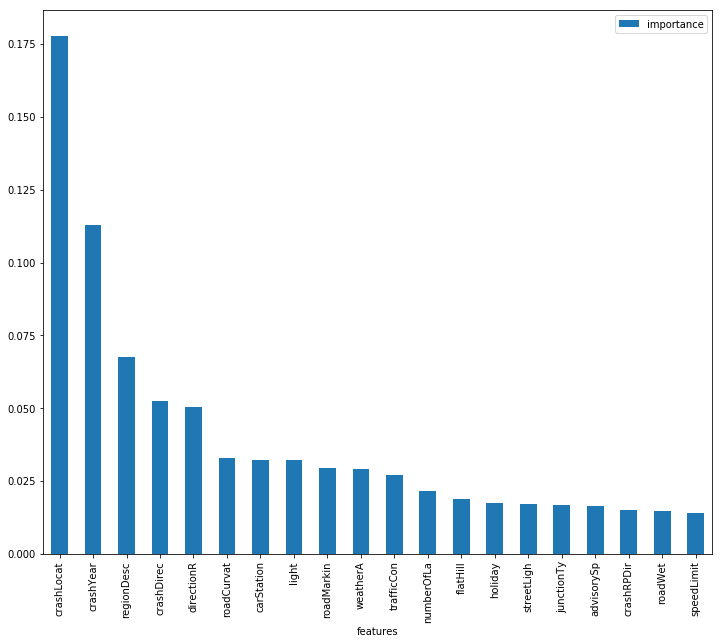

In [18]:
f_imp[:20].plot(kind='bar', figsize=(12,10));

Features such as speed limit, if a vehicle is at a junction, or the # of lanes influenced the amount of crashes

In [19]:
f_imp_sel = f_imp[f_imp['importance'] > 0.0001] #get df where feature importance is greater 

In [20]:
len(f_imp_sel.index), len(f_imp.index) #get shape of index

(64, 68)

In [21]:
y = df.fatalCount

In [22]:
df_imp = df[f_imp_sel.index]
df_imp.shape

(674321, 64)

In [23]:
#Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(df_imp, y, test_size=0.33, random_state=42)

In [ ]:
m = RandomForestRegressor(n_estimators=50, oob_score=True)
m.fit(X_train, y_train)

In [ ]:
print_score(m)

*Test different regressors* - based on testing and revising

In [ ]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=5, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=25, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=25, max_features= 0.5,oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=25, max_features= 0.5, min_samples_split=0.1)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=25, max_features= 0.5, min_samples_split=0.1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)